# Molecules - Task 

* Classify the molecules of the validation set using kNN 
* Distance: approximate Graph Edit Distance (GED)


## Data 

We have .gxl files. Those are XMLs with a lot of information. 
→ Only use the chemical symbol node label and the unlabeled, undirected edges:
``` 
    <node id="_1">
        <attr name="symbol">
            <string>C</string>
        </attr>
    </node>
     <edge from="_1" to="_2">
     </edge> 
```


Real example: 
Node 1: 

```
<node id="_1">
    <attr name="symbol">
        <string>O  </string>
    </attr>
    <attr name="chem">
        <int>2</int>
    </attr>
    <attr name="charge">
        <int>0</int>
    </attr><attr name="x">
        <float>4.9921</float>
    </attr>
    <attr name="y">
        <float>1.6561
        </float>
    </attr>
</node>
```

Edges from Node 1: 

```
<edge from="_1" to="_2">
    <attr name="valence"> 
    <int>1</int>
    </attr>
</edge>
```

## Parse Data correctly 


In [1]:
import xml.etree.ElementTree as ET
import os 
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def create_graph(filepath):
    tree = ET.parse(filepath)
    molecules = defaultdict(list)
  
    for node in tree.findall('.//node'):
        for key, val in node.attrib.items():
            molecules['nodes'].append(int(val.replace("_", "")))
    for edge in tree.findall('.//edge'):
        molecules['edges'].append([int(edge.attrib['from'].replace('_', '')), int(edge.attrib['to'].replace('_', ''))])
    for symbol in tree.findall('.//attr'):
        if(symbol.attrib['name'] == 'symbol'):
            molecules['symbols'].append([symbol[0].text.strip()])
    for node in molecules['nodes']:
        counter = 0
        for edge in molecules['edges']:
            if node in edge:
                counter += 1
        molecules['adj_edges'].append(counter)
    return molecules


#check if all valid files can be transformed
graphs = []
for fn in os.scandir('../Molecules/MoleculesClassification/gxl/'):
    # Only include XML files
    if not fn.name.endswith('.gxl'): 
        continue
    graphs.append(create_graph(fn))
print(graphs[3])
print(graphs[1])

defaultdict(<class 'list'>, {'nodes': [1, 2, 3, 4, 5, 6, 7, 8], 'edges': [[1, 2], [2, 3], [3, 4], [4, 5], [1, 6], [1, 7], [1, 8], [5, 6]], 'symbols': [['S'], ['O'], ['C'], ['C'], ['C'], ['O'], ['O'], ['O']], 'adj_edges': [4, 2, 2, 2, 2, 2, 1, 1]})
defaultdict(<class 'list'>, {'nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'edges': [[1, 2], [1, 3], [3, 4], [3, 5], [4, 6], [4, 7], [5, 8], [5, 9], [7, 10], [10, 11], [9, 10]], 'symbols': [['N'], ['O'], ['C'], ['C'], ['C'], ['N'], ['N'], ['O'], ['N'], ['C'], ['C']], 'adj_edges': [2, 1, 3, 3, 3, 1, 2, 1, 2, 3, 1]})


In [2]:
import random
import math

def load_set(set_name, path):
    graphs, labels = [], []
    file=open(path+set_name,"r")
    lines = file.readlines()
    for line in lines:
        file_name = line.split(" ")[0]
        label = line.split(" ")[1].strip()
        graph_path = path + 'gxl' + "/" + file_name + ".gxl"
        graphs.append(create_graph(graph_path))
        labels.append(label)
    return graphs, labels    
        
graphs_train, labels_train = load_set("train.txt", "../Molecules/MoleculesClassification/")
graphs_valid, labels_valid = load_set("valid.txt", "../Molecules/MoleculesClassification/")

def split_data(graphs, labels):
    indices = list(range(len(graphs)))
    random.shuffle(indices)
    x = math.floor(0.7*len(graphs))
    split_train = indices[:x]
    split_test = indices[x:]
    train_graphs = [graphs[i] for i in split_train]
    train_labels = [labels[i] for i in split_train]
    test_graphs = [graphs[i] for i in split_test]
    test_labels = [labels[i] for i in split_test]     
    return train_graphs, train_labels, test_graphs, test_labels

train_graphs, train_labels, test_graphs, test_labels = split_data(graphs_train, labels_train)

print(train_graphs[0])

defaultdict(<class 'list'>, {'nodes': [1, 2, 3, 4, 5, 6, 7, 8], 'edges': [[1, 2], [2, 3], [3, 4], [4, 5], [1, 6], [1, 7], [1, 8], [5, 6]], 'symbols': [['S'], ['O'], ['C'], ['C'], ['C'], ['O'], ['O'], ['O']], 'adj_edges': [4, 2, 2, 2, 2, 2, 1, 1]})


## Task
* Compute approximate GED between pairs of molecules (every molecule from valid set with every molecule from train set) with bipartite graph matching (lecture 10, slide 21)
* Build cost matrix (Dirac)
    * Use Dirac cost function for GED (optimize Cn and Ce) (lecture 9, slide 36)
    * Node substitution: 2*Cn if symbols ≠, 0 otherwise Node deletion/insertion: Cn
    * Edge deletion/insertion: Ce
* Hungarian Algorithm: to find optimal assignment
* Derive edit path costs from the result (distance for classification)

* kNN for classification (optimize for k)
  

### 1. Calculate GED between pairs of molecules, bipartite graph matching 

### Bipartite graph matching procedure: 
![BP_image](BP_image.jpg)

#### Cost Matrix: 
1.  Upper left: substitutions (nodes plus adjacent edges) 
2.  Upper right: deletions (nodes plus adjacent edges) 
3.  Lower left: insertions (nodes plus adjacent edges)
4.  Lower right: dummy assignments (ε → ε)

In [3]:
#input: two dicts from graphs list 
def cost_matrix(graph1, graph2, Cn, Ce): 
    n = len(graph1['nodes'])
    m = len(graph2['nodes'])
    l = n+m
    cost_matrix = np.zeros((l,l))
    #upper left, substitutions 
    for i in range(0, n):
        for j in range(0, m):
            if graph1['symbols'][i] != graph2['symbols'][j]:
                difference_edges = abs(graph1['adj_edges'][i]- graph2['adj_edges'][j])
                cost_matrix.itemset((i, j), 2*Cn + difference_edges*Ce)
    #upper right: deletions; here one wants to compute the costs of deleting one node + edge (base graph) 
    for i in range(0,n):
        for j in range(m+1,l):
            cost_matrix.itemset((i, j), np.Inf)
            cost_del = (Cn + graph1['adj_edges'][i]*Ce)
            cost_matrix.itemset((i, m+i), cost_del)
   
    #lower left: insertions -- here one wants to compute the cost to insert a node from graph2 into graph1 
    for i in range(n+1, l):
        for j in range(0, m):
            cost_matrix.itemset((i, j), np.Inf)
            cost_ins = (Cn + graph2['adj_edges'][j]*Ce)
            cost_matrix.itemset((n+j, j), cost_ins)
    return cost_matrix

print(cost_matrix(train_graphs[0], train_graphs[1], 1, 1))


[[ 0.  3.  4.  4.  4.  4.  4.  4.  5. inf inf inf inf inf inf inf]
 [ 3.  3.  2.  2.  2.  2.  2.  2.  0.  3. inf inf inf inf inf inf]
 [ 3.  0.  0.  2.  0.  0.  0.  0.  0. inf  3. inf inf inf inf inf]
 [ 3.  0.  0.  2.  0.  0.  0.  0.  0. inf inf  3. inf inf inf inf]
 [ 3.  0.  0.  2.  0.  0.  0.  0.  0. inf inf inf  3. inf inf inf]
 [ 3.  3.  2.  2.  2.  2.  2.  2.  0. inf inf inf inf  3. inf inf]
 [ 2.  4.  3.  3.  3.  3.  3.  3.  0. inf inf inf inf inf  2. inf]
 [ 2.  4.  3.  3.  3.  3.  3.  3.  0. inf inf inf inf inf inf  2.]
 [ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [inf  4. inf inf inf inf inf inf  0.  0.  0.  0.  0.  0.  0.  0.]
 [inf inf  3. inf inf inf inf inf  0.  0.  0.  0.  0.  0.  0.  0.]
 [inf inf inf  3. inf inf inf inf  0.  0.  0.  0.  0.  0.  0.  0.]
 [inf inf inf inf  3. inf inf inf  0.  0.  0.  0.  0.  0.  0.  0.]
 [inf inf inf inf inf  3. inf inf  0.  0.  0.  0.  0.  0.  0.  0.]
 [inf inf inf inf inf inf  3. inf  0.  0.  0.  0.  0.  0.  0. 

In [4]:
from scipy.optimize import linear_sum_assignment
def graph_edit_distance(graph1, graph2, Cn, Ce):
    c = cost_matrix(graph1, graph2, Cn, Ce)
    row_ind, col_ind = linear_sum_assignment(c)
    return c[row_ind, col_ind].sum()

print(graph_edit_distance(train_graphs[0], train_graphs[1], 1,1))

def distance_matrix(test, train, Cn, Ce):
    distance_matrix = np.zeros((len(test), len(train)))
    for index_test, graph_test in enumerate(test):
        for index_train, graph_train in enumerate(train):
            distance_matrix.itemset((index_test,index_train), graph_edit_distance(graph_test, graph_train, Cn, Ce))
            
    return distance_matrix

dist = distance_matrix(test_graphs, train_graphs, 1, 1)
np.savetxt('distance_matrix.csv', dist, delimiter = ',')
print(dist)

7.0
[[  2.  12.  16. ...  14.  10. 153.]
 [ 39.  30.  21. ...  20.  31. 112.]
 [ 10.   6.   4. ...   6.  12. 141.]
 ...
 [ 12.   5.   6. ...   8.  12. 138.]
 [ 17.  10.   2. ...   0.  21. 139.]
 [ 12.   7.   0. ...   4.  14. 142.]]


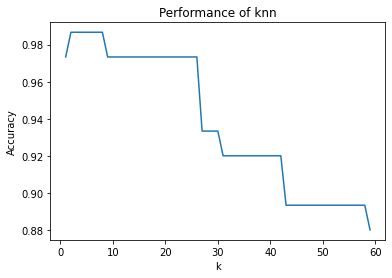

[1, 2, 3, 4, 5, 6, 7]


In [5]:
def knn(dist_mat, k, test_labels, train_labels):
    correct = 0
    for index, row in enumerate(dist_mat):
        smallest_k_values = np.argsort(row)[:k]
        train_labels_k = [train_labels[i] for i in smallest_k_values]
        count_a = train_labels_k.count('a')
        count_i = k - count_a
        if(count_a >= count_i):
            predicted_label = 'a'
        else:
            predicted_label = 'i'
        correct += int(predicted_label == test_labels[index])
    return correct/len(test_labels)

accuracies = []
ks = range(1, 60)
for k in ks:
    accuracy = knn(dist, k, test_labels, train_labels)
    accuracies.append(accuracy)
fig, ax = plt.subplots()
ax.plot(ks, accuracies)
ax.set(xlabel="k",
       ylabel="Accuracy",
       title="Performance of knn")
plt.show()

indices = [index for index, item in enumerate(accuracies) if item == max(accuracies)]
print(indices)

## Linear Sum Assignment


cn: 0.2 ce: 1
(3, 0.996)


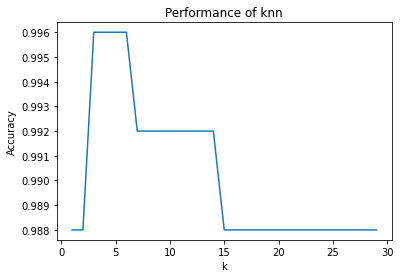

cn: 0.5 ce: 1
(3, 0.996)


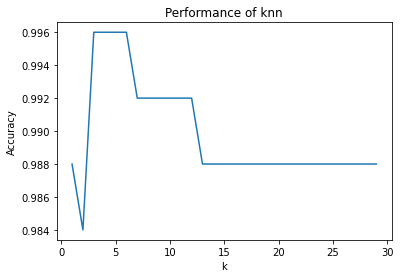

cn: 1 ce: 1
(3, 0.996)


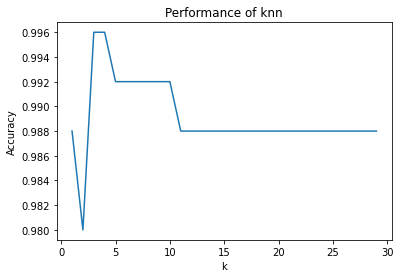

cn: 2 ce: 1
(3, 0.992)


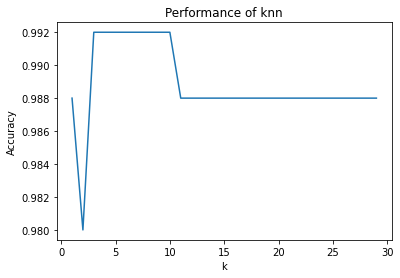

cn: 5 ce: 1
(3, 0.992)


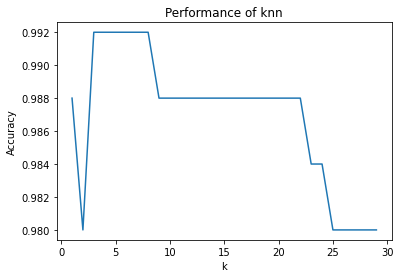

cn: 10 ce: 1
(3, 0.992)


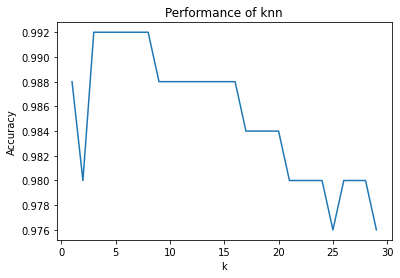

In [6]:
for cn in (0.2, 0.5, 1, 2, 5, 10):
    ce = 1
    print("cn:", cn, "ce:", ce)
    dist_ = distance_matrix(graphs_valid, graphs_train, cn, ce)

    accuracies = []
    ks = range(1, 30)
    max_accuracy = (-1, 0)
    for k in ks:
        accuracy = knn(dist_, k, labels_valid, labels_train)
        accuracies.append(accuracy)
        if(accuracy > max_accuracy[1]):
            max_accuracy = (k, accuracy)

    print(max_accuracy)

    fig, ax = plt.subplots()
    ax.plot(ks, accuracies)
    ax.set(xlabel="k",
           ylabel="Accuracy",
           title="Performance of knn")
    plt.show()



In [7]:
accuracy = knn(dist_, 3,labels_valid, labels_train)
print("Accuracy on valid with k = 3: ", accuracy)

Accuracy on valid with k = 3:  0.992


In [15]:
def load_graphs(path):
    graphs = []
    names = []
    for fn in os.scandir(path):
        if not fn.name.endswith('.gxl'):
            continue
        graphs.append(create_graph(fn))
        names.append(fn.name.split('.gxl')[0])
    return graphs, names



competition_graphs, competition_names = load_graphs('../Molecules/MoleculesClassification/TestMolecules/gxl/')

dist = distance_matrix(competition_graphs, train_graphs, 1, 1)
graphs_labeled = []
k=3
i = 0
for index, row in enumerate(dist):
    smallest_k_values = np.argsort(row)[:k]
    train_labels_k = [train_labels[i] for i in smallest_k_values]
    count_a = train_labels_k.count('a')
    count_i = k - count_a
    if(count_a >= count_i):
        graphs_labeled.append(str(competition_names[i]) + ',a')
    else:
        graphs_labeled.append(str(competition_names[i]) + ',i')
    i+=1
if(i != len(competition_names)):
    print('error', len(competition_graphs), ':', i)
else:
    np.savetxt('mol.csv', graphs_labeled, delimiter = '\n', fmt = '%s')
    print('success')

success
